## CT5133 / CT5145 Deep Learning (/Online) 2023-2024 (Part 2, James McDermott)

## Assignment 2


* Student ID(s): 23103188
* Student name(s): Sreelakshmi Anjilimarayil Shyjumon

* Student ID(s): 23103775
* Student name(s): Vineela Parepalli Laxmi Buddhini

In this assignment, we'll create an image classifier, inspect the embeddings it produces, try out different hyperparameters, and compare to a pretrained model.

### Due date

As announced on Canvas.

### Weighting

20% of the module.

### Tasks

1. Load and preprocess the `CIFAR-10` dataset using the supplied code.
2. Create a small convolutional model for classifying this dataset. Use a final `Dense(10)` layer for classification. Before that, use a `Dense(z)` layer, where `z` is a hyperparameter with value `z=2` for now.
3. Train the model and report performance. Ensure the training log is visible in the notebook. By looking at the training loss and validation loss, decide how many epochs are needed.
4. Visualise the output of the penultimate `Dense(z)` layer, on a subset of test data. One approach could use the supplied `visualise_embedding` function.
5. Repeat Steps 3-4 for some variants of the network: try `z=2` and `z=10`, and try some changes in architecture such as using different kernel parameters, more or different layers, or a different optimiser. And/or try using different fractions of the data during training.
6. Load a pretrained model, freeze it, discard its classification head, and add a new classification head suitable for the task. Again repeat Steps 3-4 for this network (choosing a suitable layer for visualisation, which can again be a `Dense(2)`, if you like). (You don't need to repeat Step 5 for this network.) Note: if the pretrained model does not like the CIFAR-10 image size (32x32), code for resizing images is supplied.
7. For each model you created, and for the pretrained model, comment (using Markdown cells in the notebook) on the differences in the embedding: how many dimensions are there, and why? Ignoring classes, what distribution of data do you observe and why? Now focussing on classes, what do you observe? Which embeddings are better? Relate this to performance of the classifier in each case. This part must be written in your own words.


### Grading

1. 0 marks.
2. 3 marks for a conv model with no conceptual errors, with a Dense(2) layer. Partial marks: 1 mark for any model that compiles ok.
3. 2 marks for a successful training log, with epochs chosen based on correct reasoning with the loss values. Partial marks: 1 mark for any training log.
4. 0 marks.
5. 5 marks for trying multiple sensible variations, well-organised. Partial marks: 2 marks if only 1-2 variations, or they are not sensible (eg, they reveal a misunderstanding of what different layers do). 1 mark for some attempt at variation leading to a different training log, versus (3).
6. 4 marks. 1 for loading and freezing and discarding head. 2 for appropriate design of classification head and 1 for training. 1 for visualisation.
7. 6 marks. Full marks for answers to all, demonstrating understanding of all issues. Guideline: 1 sentence for each answer, for each model, is likely sufficient. Partial marks: 3 marks for giving observations without understanding of what would be desirable properties in embeddings, or relation to classifier performance.

Marks will be subtracted for issues such as existing code used without attribution, or generative AI used without attribution.

Total: 20 marks



### Some rules

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras using the Tensorflow or PyTorch backend, or in PyTorch itself.

* **Generative AI** can be used to generate the code for this assignment. Every piece of generated material must be individually and clearly marked and attributed to a specific model, with a URL linking to the model, and must include the prompt(s) used, and a comment on why you chose to use Generative AI for this particular task or problem. The student is still required to understand all details of their own submission. Low grades will be awarded where it is clear generative AI has been used without attribution. When commenting on the embeddings, you must look at the embedding with your own eyes and comment on it yourself, in your own words.

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code from the internet, **if you provide a citation with URL for each specific part**. A set of references at the bottom of the notebook is not sufficient.

* **Submission**: after completing your work in this Jupyter notebook, submit your notebook on Canvas in `.ipynb` format.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.

### Some code is provided:

In [15]:
from keras.optimizers import Adam, RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121, VGG16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

In [2]:
# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

In [3]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(0)

In [4]:
def subsample(X, y=None, p=0.1):
    # work with a fraction of the data
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]

def visualise_embedding(X, y=None, p_subsample=None):
    """
    Visualise an embedding X as a scatterplot.

    Optionally visualise class labels y at the same time as colours.

    If X has >2 dimensions, use UMAP to reduce to 2.

    User can supply eg subsample=0.01, to show a small fraction of the data.
    """
    n_samples, n_features = X.shape

    # check X and y shapes compatible
    if y is not None:
        if n_samples != y.shape[0]:
            raise ValueError(f"X and y have incompatible shapes {X.shape} and {y.shape}")

        if len(y.shape) == 2:
            # these are probably one-hot encoded, so convert to integer
            y = np.argmax(y, axis=1)

    # work with only a fraction of the data
    if p_subsample is not None:
        if y is None:
            X = subsample(X, p_subsample)
        else:
            X, y = subsample(X, y, p_subsample)

    # ensure we have 2 dimensions, using UMAP for dim reduction if needed
    if n_features > 2:
        import umap # pip install umap-learn
        reducer = umap.UMAP()
        X = StandardScaler().fit_transform(X) # need all dimensions to be on approx same scale
        X = reducer.fit_transform(X) # UMAP reduce to 2D

    # Visualization
    colors = plt.get_cmap('tab10')  # Get a color map with 10 distinct colors

    plt.figure(figsize=(10, 8))
    for i in range(10): # for 10 classes in CIFAR-10
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {i}', color=colors(i))

    # reflect the dim reduction in axis labels if needed
    if n_features == 2:
        axis0_lab = "z0"
        axis1_lab = "z1"
    else:
        axis0_lab = "UMAP0"
        axis1_lab = "UMAP1"

    plt.legend()
    plt.xlabel(axis0_lab)
    plt.ylabel(axis1_lab)
    plt.show()

Task 1

The CIFAR 10 dataset contains images of animals, aeroplanes, vehicles, etc. which are classified into 10 classes. In this assignment, we are evaluating the performance of Convolutional Neural Network on the dataset.
The dataset is loaded and preprocessed by normalising and one-hot encoding before feeding into the CNN architecture.
Flattening is carried out to convert the input tensor into an array of one dimension. The images are rotated, flipped, etc. before fitting to the model to enable the model to detect the pattern from different angles and thereby improve accuracy.

In [5]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

170498071/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [6]:
# keep only a small amount of the training data for fast prototyping
# later, we could train on all data, by commenting out this line
x_train, y_train = subsample(x_train, y_train, 0.2)

# convert image data to float16 to save some memory
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

In [7]:
# some pretrained models require a specific image *size*.
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(96, 96) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_96px = resizing_layer(x_train)
x_test_96px = resizing_layer(x_test)

Per Karpathy: look at your data! And make sure to look at it immediately before training, after any preprocessing, in case of preprocessing bugs. You want to see exactly what the network will see. (Unfortunately we have to give a `float32` to keep Matplotlib `imshow` happy.)

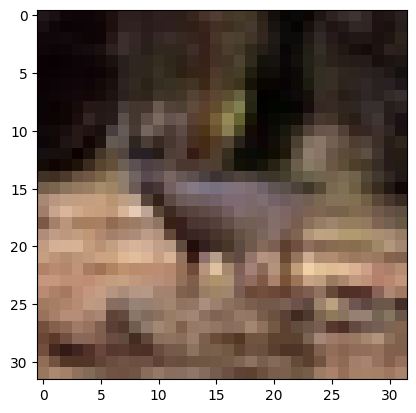

In [8]:
plt.imshow(x_train[50].astype('float32'));

Task 2

In task 2, a basic convolutional network is used. This sequential model constitutes two Convolutional layers, two MaxPooling layers and 2 dense layers with the final one being the output layer.

In [9]:

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define a new model with a smaller architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(2, activation='relu'),  # Added a Dense layer with 2 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

# Compile the new model with the same optimizer and loss function
model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])




Task 3

In task 3, the dataset was fit into the model, and we obtained a test accuracy of 18.3%. After the 5th epoch, the acuracy kept fluctuating around 0.18. This indicates that the model is underfitting and is too simple to capture the underlying patterns in the image data.

Epoch 1/10
218/218 [==============================] - 26s 115ms/step - loss: 2.2922 - accuracy: 0.1264 - val_loss: 2.3030 - val_accuracy: 0.1002
Epoch 2/10
218/218 [==============================] - 25s 116ms/step - loss: 2.3027 - accuracy: 0.1033 - val_loss: 2.3027 - val_accuracy: 0.1005
Epoch 3/10
218/218 [==============================] - 25s 114ms/step - loss: 2.2602 - accuracy: 0.1474 - val_loss: 2.1833 - val_accuracy: 0.1732
Epoch 4/10
218/218 [==============================] - 33s 153ms/step - loss: 2.1552 - accuracy: 0.1703 - val_loss: 2.0708 - val_accuracy: 0.1888
Epoch 5/10
218/218 [==============================] - 25s 116ms/step - loss: 2.0826 - accuracy: 0.1813 - val_loss: 2.0507 - val_accuracy: 0.1868
Epoch 6/10
218/218 [==============================] - 25s 117ms/step - loss: 2.0438 - accuracy: 0.1882 - val_loss: 2.0086 - val_accuracy: 0.1916
Epoch 7/10
218/218 [==============================] - 26s 121ms/step - loss: 2.0152 - accuracy: 0.1912 - val_loss: 2.0181 - val_ac

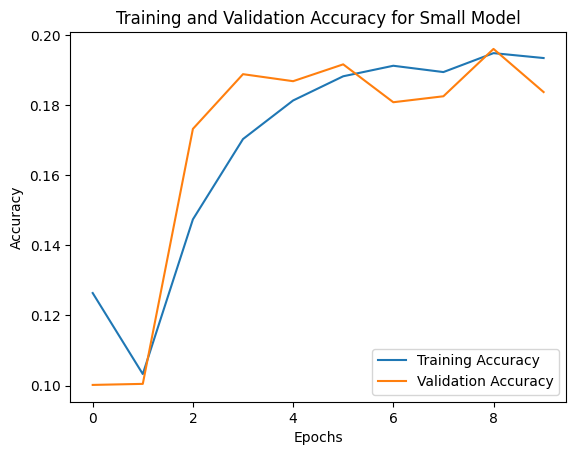

313/313 [==============================] - 5s 15ms/step - loss: 1.9892 - accuracy: 0.1837
Test Loss for Small Model: 1.9891855716705322, Test Accuracy for Model: 0.18369999527931213


In [10]:
# Train the model and report performance
history = model.fit(datagen.flow(x_train, y_train, batch_size=46),
                                epochs=10,
                                validation_data=(x_test, y_test))

# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Small Model')
plt.legend()
plt.show()

# Evaluate the model on the test data
small_test_loss, small_test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss for Small Model: {small_test_loss}, Test Accuracy for Model: {small_test_accuracy}")

Task 4

The embedding also aligns with this inference as only one neuron(z0) is able to learn from the data while the other is not(z1). We obtain the embedding in which the points are stacked on top of each other with points beneath the ones on the top. This indicates that the model is not successful in effectively classifying the points and has less discriminatory power.

313/313 [==============================] - 6s 17ms/step


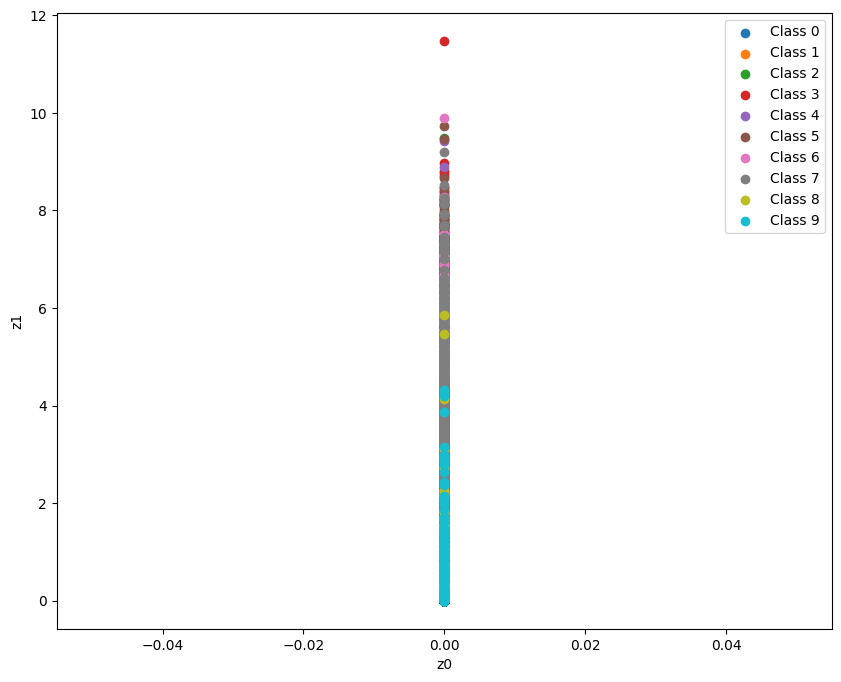

In [11]:
# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

Task 5

In task 5, we tried to improve the performance of the model by changing certain parameters in the model.

As the first change, we kept the previous code and just replaced the 'Adam' optimizer by 'RMSprop' optimizer. But this turned out be a bad choice by itself as the accuracy and loss remains the same throughout the epochs. The accuracy is only 10% and is consistent every time. This shows that the model is not able to learn effectively, and the architecture needs to be further adjusted to improve it. The training plot and embedding side with the inferences. The embedding plot can be seen as just one point on the graph underneath which all the points are lying. The means that both the neurons are not able to learn from the data which resulted in bad discriminatory power.

Optimizer

Epoch 1/10
218/218 [==============================] - 29s 130ms/step - loss: 2.3029 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
218/218 [==============================] - 26s 119ms/step - loss: 2.3025 - accuracy: 0.1031 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/10
218/218 [==============================] - 23s 107ms/step - loss: 2.3025 - accuracy: 0.1005 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 4/10
218/218 [==============================] - 25s 116ms/step - loss: 2.3025 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/10
218/218 [==============================] - 24s 110ms/step - loss: 2.3025 - accuracy: 0.1012 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 6/10
218/218 [==============================] - 30s 136ms/step - loss: 2.3024 - accuracy: 0.1036 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 7/10
218/218 [==============================] - 26s 120ms/step - loss: 2.3024 - accuracy: 0.1027 - val_loss: 2.3030 - val_ac

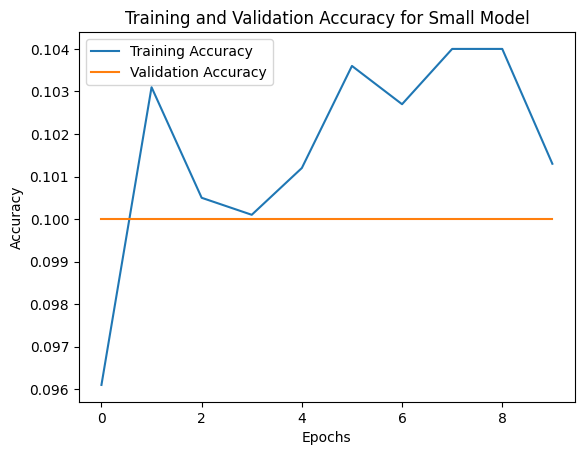

313/313 [==============================] - 6s 19ms/step - loss: 2.3030 - accuracy: 0.1000
Test Loss for Small Model: 2.3029661178588867, Test Accuracy for Model: 0.10000000149011612
313/313 [==============================] - 5s 17ms/step


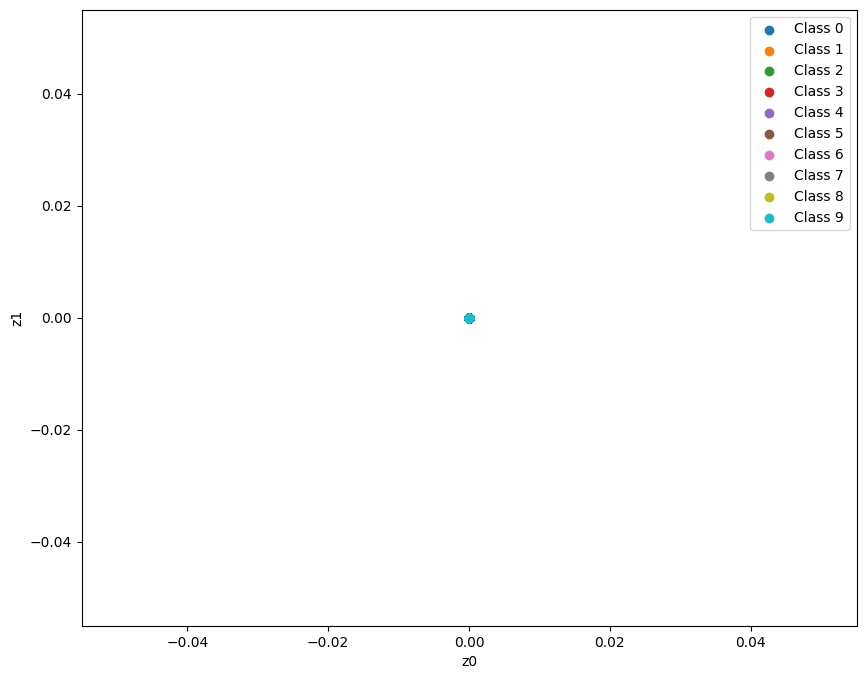

In [12]:


# Define the optimizer
optimizer = RMSprop(learning_rate=0.01)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define a new model with a smaller architecture
model_RMSprop = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(2, activation='relu'),  # Added a Dense layer with 2 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

# Compile the new model with the same optimizer and loss function
model_RMSprop.compile(optimizer='RMSprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
# Train the small model and report performance
history = model_RMSprop.fit(datagen.flow(x_train, y_train, batch_size=46),
                                epochs=10,
                                validation_data=(x_test, y_test))

# Visualize training history for the small model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Small Model')
plt.legend()
plt.show()

# Evaluate the small model on the test data
small_test_loss, small_test_accuracy = model_RMSprop.evaluate(x_test, y_test)
print(f"Test Loss for Small Model: {small_test_loss}, Test Accuracy for Model: {small_test_accuracy}")

# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model_RMSprop.input, outputs=model_RMSprop.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

Dropout + Layers

As a second improvement attempt, we tried adding extra layers to the network while keeping the RMSprop optimizer. We added a third Convolutional layer as well as two more Dense layers combined with a Dropout layer with rate = 0.5. The model showed huge improvement in distinguishing the classes. The accuracy increased to 33% which can also be reflected in the embedding. The classes can be seen as more separated compared to the previous embeddings.

Epoch 1/10
218/218 [==============================] - 29s 126ms/step - loss: 2.3020 - accuracy: 0.1009 - val_loss: 2.2927 - val_accuracy: 0.1253
Epoch 2/10
218/218 [==============================] - 27s 122ms/step - loss: 2.2803 - accuracy: 0.1458 - val_loss: 2.2453 - val_accuracy: 0.1731
Epoch 3/10
218/218 [==============================] - 27s 123ms/step - loss: 2.2346 - accuracy: 0.1729 - val_loss: 2.1790 - val_accuracy: 0.2039
Epoch 4/10
218/218 [==============================] - 26s 120ms/step - loss: 2.1727 - accuracy: 0.1889 - val_loss: 2.1435 - val_accuracy: 0.1895
Epoch 5/10
218/218 [==============================] - 27s 125ms/step - loss: 2.1110 - accuracy: 0.1991 - val_loss: 2.0149 - val_accuracy: 0.2119
Epoch 6/10
218/218 [==============================] - 26s 120ms/step - loss: 2.0416 - accuracy: 0.2114 - val_loss: 2.0038 - val_accuracy: 0.2260
Epoch 7/10
218/218 [==============================] - 27s 124ms/step - loss: 1.9752 - accuracy: 0.2472 - val_loss: 1.9235 - val_ac

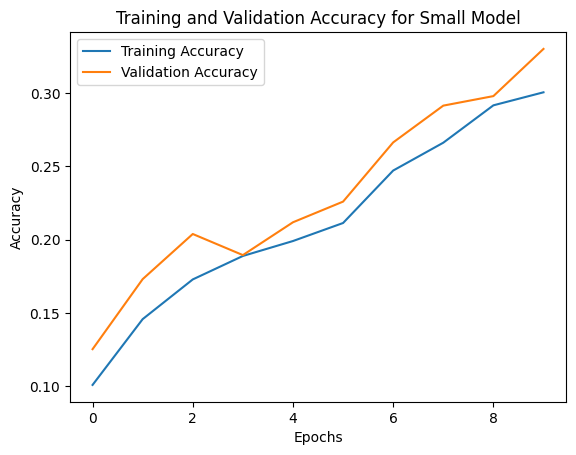

313/313 [==============================] - 5s 15ms/step - loss: 1.7582 - accuracy: 0.3302
Test Loss for Small Model: 1.7581897974014282, Test Accuracy for Model: 0.3301999866962433
313/313 [==============================] - 5s 16ms/step


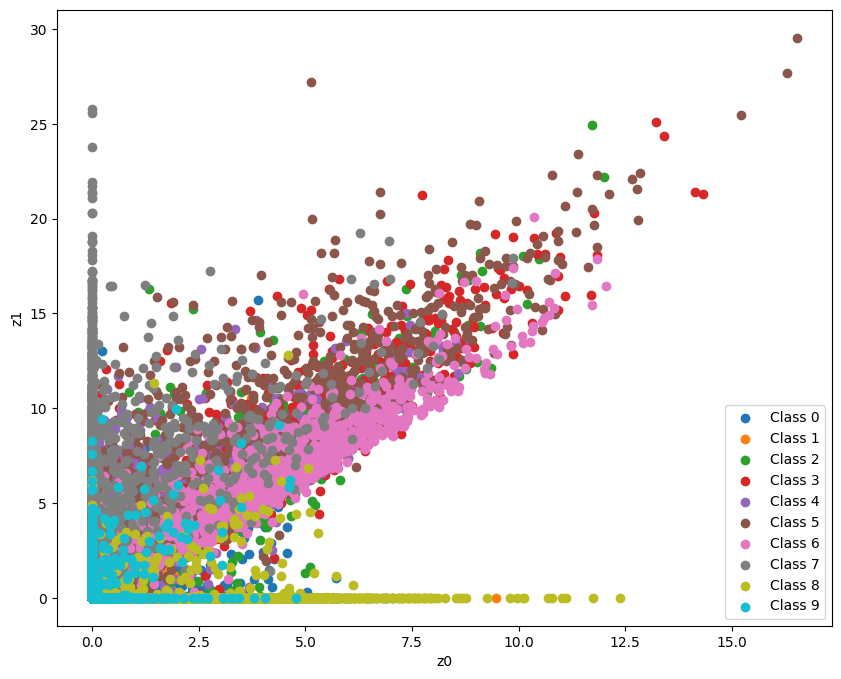

In [14]:



# Define the optimizer
optimizer = RMSprop(learning_rate=0.01)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define a new model with a smaller architecture
model_RMSprop_ExtraLayers = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='relu'), # z=2
    Dense(10, activation='softmax')
])

# Compile the new model with the same optimizer and loss function
model_RMSprop_ExtraLayers.compile(optimizer='RMSprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
# Train the model and report performance
history = model_RMSprop_ExtraLayers.fit(datagen.flow(x_train, y_train, batch_size=46),
                                epochs=10,
                                validation_data=(x_test, y_test))

# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Small Model')
plt.legend()
plt.show()

# Evaluate the small model on the test data
small_test_loss, small_test_accuracy = model_RMSprop_ExtraLayers.evaluate(x_test, y_test)
print(f"Test Loss for Small Model: {small_test_loss}, Test Accuracy for Model: {small_test_accuracy}")

# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model_RMSprop_ExtraLayers.input, outputs=model_RMSprop_ExtraLayers.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

Z=2, epochs=50

Additionally, we also increased the number of epochs to 50 to see how it affects the model performance. The z value for the second last dense layer is set as 2 here and the learning rate for the optimizer was reduced to 0.0001. As expected, the model accuracy increased to 46% and the embeddings also shows the classes as separate clusters.

Epoch 1/50
1563/1563 [==============================] - 99s 63ms/step - loss: 2.2951 - accuracy: 0.1021 - val_loss: 2.2824 - val_accuracy: 0.1047
Epoch 2/50
1563/1563 [==============================] - 98s 63ms/step - loss: 2.2660 - accuracy: 0.1269 - val_loss: 2.2326 - val_accuracy: 0.1248
Epoch 3/50
1563/1563 [==============================] - 97s 62ms/step - loss: 2.2057 - accuracy: 0.1334 - val_loss: 2.1424 - val_accuracy: 0.1409
Epoch 4/50
1563/1563 [==============================] - 99s 63ms/step - loss: 2.1164 - accuracy: 0.1521 - val_loss: 2.0505 - val_accuracy: 0.2043
Epoch 5/50
1563/1563 [==============================] - 110s 70ms/step - loss: 2.0287 - accuracy: 0.2063 - val_loss: 1.9431 - val_accuracy: 0.2098
Epoch 6/50
1563/1563 [==============================] - 101s 64ms/step - loss: 1.9585 - accuracy: 0.2200 - val_loss: 1.8637 - val_accuracy: 0.2429
Epoch 7/50
1563/1563 [==============================] - 102s 65ms/step - loss: 1.9082 - accuracy: 0.2360 - val_loss: 1.850

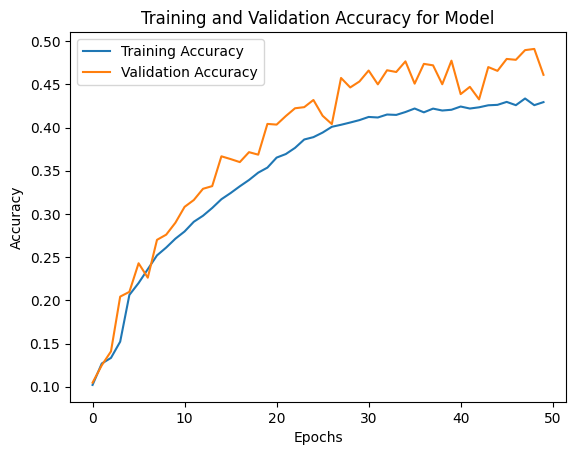

313/313 [==============================] - 3s 11ms/step - loss: 1.5440 - accuracy: 0.4610
Test Loss: 1.5440236330032349, Test Accuracy: 0.460999995470047
313/313 [==============================] - 3s 10ms/step


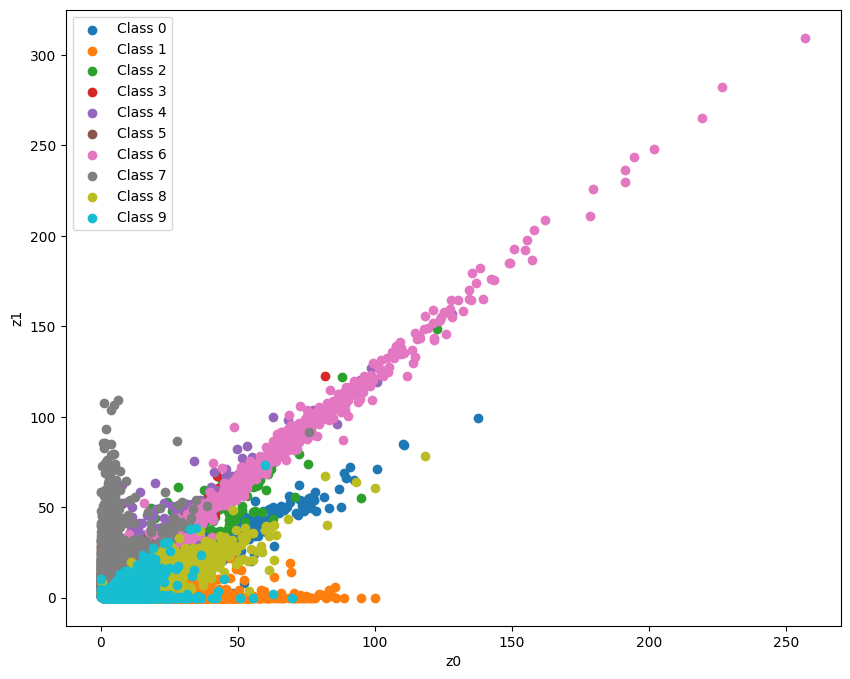

In [ ]:


# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define a new model with a larger architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='relu'), # z=2
    Dense(10, activation='softmax')
])

# Define the optimizer
optimizer = RMSprop(learning_rate=0.0001)

# Compile the new model with the RMSprop optimizer and categorical_crossentropy loss function
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and report performance
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,  # Increase the number of epochs for better training
                    validation_data=(x_test, y_test))

# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Model')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

z=10, epochs=50

We also carried out the same improvement for z=10 in the second last dense layer. This resulted in a huge improvement in accuracy, which is 68.1%. The model was able to carry out the classification more efficiently. The embeddings also confirm this as the classes can be seen as separate clusters in the plot.

Epoch 1/50
1563/1563 [==============================] - 37s 22ms/step - loss: 2.2507 - accuracy: 0.1424 - val_loss: 2.1205 - val_accuracy: 0.1952
Epoch 2/50
1563/1563 [==============================] - 33s 21ms/step - loss: 2.0585 - accuracy: 0.2156 - val_loss: 1.8573 - val_accuracy: 0.3008
Epoch 3/50
1563/1563 [==============================] - 33s 21ms/step - loss: 1.9102 - accuracy: 0.2718 - val_loss: 1.7318 - val_accuracy: 0.3660
Epoch 4/50
1563/1563 [==============================] - 35s 22ms/step - loss: 1.8345 - accuracy: 0.3092 - val_loss: 1.6826 - val_accuracy: 0.3862
Epoch 5/50
1563/1563 [==============================] - 32s 21ms/step - loss: 1.7738 - accuracy: 0.3373 - val_loss: 1.5732 - val_accuracy: 0.4311
Epoch 6/50
1563/1563 [==============================] - 33s 21ms/step - loss: 1.7210 - accuracy: 0.3605 - val_loss: 1.5440 - val_accuracy: 0.4370
Epoch 7/50
1563/1563 [==============================] - 33s 21ms/step - loss: 1.6739 - accuracy: 0.3832 - val_loss: 1.4683 -

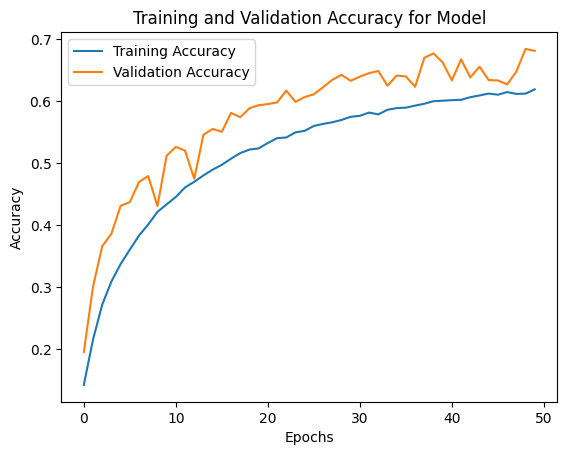

313/313 [==============================] - 1s 3ms/step - loss: 0.9539 - accuracy: 0.6810
Test Loss: 0.9539153575897217, Test Accuracy: 0.6809999942779541
313/313 [==============================] - 1s 2ms/step


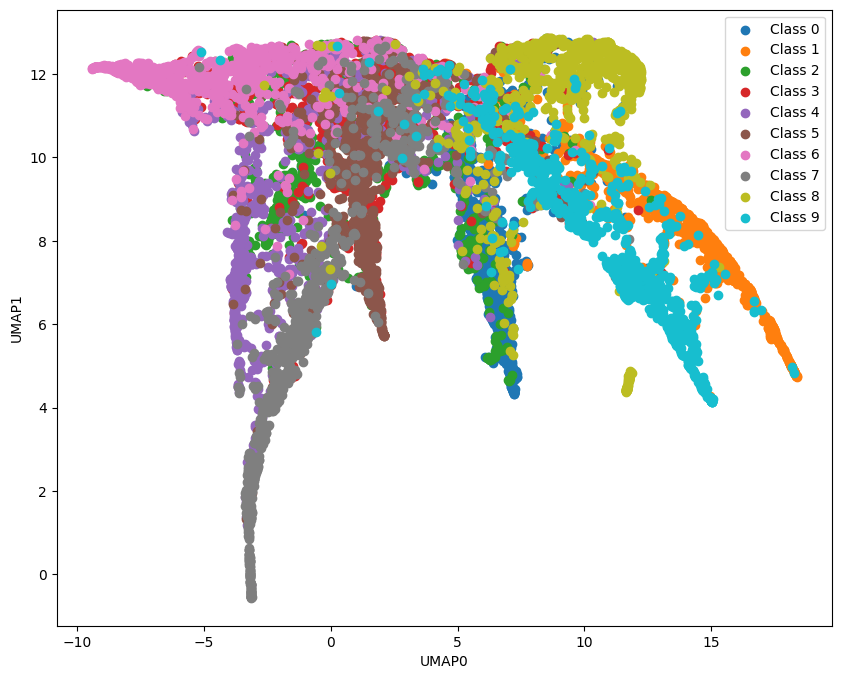

In [ ]:


# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define a new model with a larger architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'), # z=10
    Dense(10, activation='softmax')
])

# Define the optimizer
optimizer = RMSprop(learning_rate=0.0001)

# Compile the new model with the RMSprop optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and report performance
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_test, y_test))

# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Model')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

from keras.models import Model

# Define a model to get output from the penultimate Dense layer
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Get the output of the penultimate Dense layer for the test data
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualize embeddings
visualise_embedding(penultimate_output, y_test)


Task 6

DenseNet121

We used DenseNet121 as a pre-trained model. Since, it has been trained on a large dataset like ImageNet, we discarded the classification head of the model as it's specific to  ImageNet's classification task. We freezed layers to retain the knowledge stored in ImageNet classification. Added custom dense layers for fine-tuning on the dataset CIFAR-10. Compiled the model with RMSprop optimizer. We then trained the data using augmentation, and evaluated its performance on the test dataset. We plotted the training and validation accuracy over epochs and print the test loss and accuracy. Finally, visualised the output of the penultimate Dense(10) layer, on a subset of test data using the supplied visualise_embedding function.
The DenseNet121 model was able to classify the images with an accuracy of 59.74% for 10 epochs. If we increase the number of epochs, we will be able to increase the accuracy to more efficiently classify the images.

Epoch 1/10
1563/1563 [==============================] - 60s 34ms/step - loss: 2.1305 - accuracy: 0.2259 - val_loss: 1.7800 - val_accuracy: 0.3799
Epoch 2/10
1563/1563 [==============================] - 63s 40ms/step - loss: 1.8016 - accuracy: 0.3680 - val_loss: 1.5238 - val_accuracy: 0.4782
Epoch 3/10
1563/1563 [==============================] - 76s 49ms/step - loss: 1.6238 - accuracy: 0.4313 - val_loss: 1.3694 - val_accuracy: 0.5226
Epoch 4/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.5261 - accuracy: 0.4606 - val_loss: 1.3058 - val_accuracy: 0.5433
Epoch 5/10
1563/1563 [==============================] - 61s 39ms/step - loss: 1.4654 - accuracy: 0.4823 - val_loss: 1.2513 - val_accuracy: 0.5618
Epoch 6/10
1563/1563 [==============================] - 61s 39ms/step - loss: 1.4260 - accuracy: 0.4955 - val_loss: 1.2275 - val_accuracy: 0.5716
Epoch 7/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.3964 - accuracy: 0.5090 - val_loss: 1.2101 -

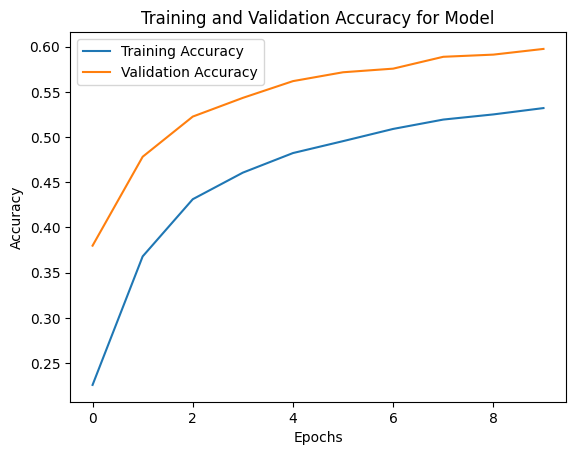

313/313 [==============================] - 5s 15ms/step - loss: 1.1573 - accuracy: 0.5974
Test Loss: 1.1572705507278442, Test Accuracy: 0.5974000096321106


In [ ]:


# Define the optimizer
optimizer = RMSprop(learning_rate=0.0001)


# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

input_shape=(32, 32, 3)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model and report performance
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_test, y_test))



# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Model')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

313/313 [==============================] - 6s 12ms/step


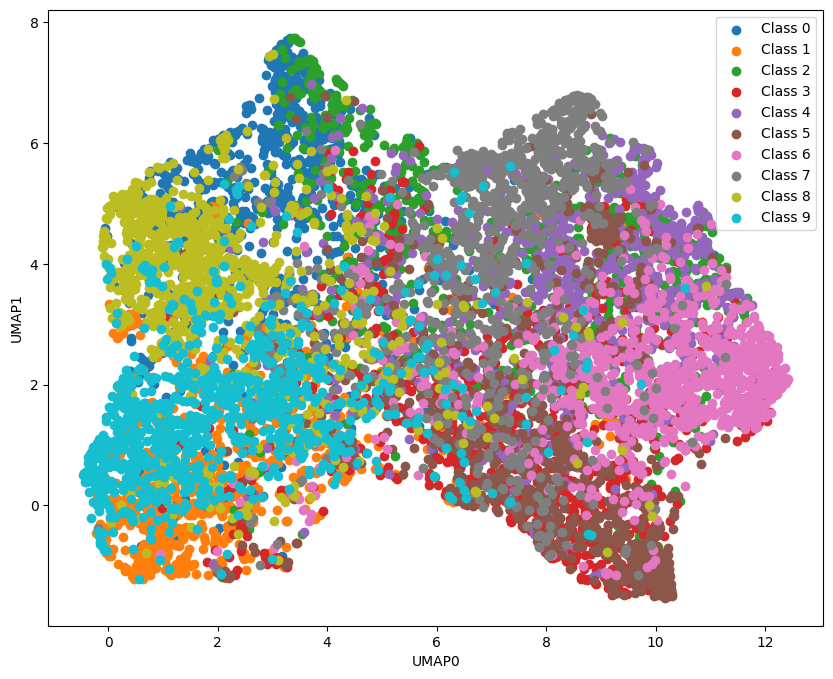

In [ ]:
# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

VGG (Visual Geometry Group)

Here we are using the Visual Geometry Group (VGG16) which is comprised of 16 layers, including 13 convolutional layers and 3 fully connected layers, and uses 3x3 filters throughout the network. With its depth of 16 layers which is capable of capturing more complex patterns in data, makes it suitable for image classification tasks. We used ImageDataGenerator to perform data augmentation, including rotation, width and height shifts, and horizontal flips. We added custom top layers including global average pooling (for reduced overfitting), dense layer with 256 units(feature extraction) and ReLU activation, dropout layer(for regularizing network) with a dropout rate of 0.5, another dense layer with 10 units and ReLU activation, and a final dense layer with softmax activation for the 10 output classes. We have also frozen all the layers of the VGG16 base model to retain the pre-trained weights. finally, plotted the validation accuracies over epochs, and visualised the output of the penultimate Dense(10) layer, on a subset of test data using the supplied visualise_embedding function.
The VGG16 model showed an accuracy of 53.03% for 10 epochs. Here as well, upon increasing the number of epochs, better accuracy and more efficient classification can be achieved.

58889256/58889256 [==============================] - 5s 0us/step
Epoch 1/10
1563/1563 [==============================] - 46s 28ms/step - loss: 2.1809 - accuracy: 0.2004 - val_loss: 1.9822 - val_accuracy: 0.3104
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.9864 - accuracy: 0.2928 - val_loss: 1.8403 - val_accuracy: 0.3507
Epoch 3/10
1563/1563 [==============================] - 45s 29ms/step - loss: 1.8664 - accuracy: 0.3425 - val_loss: 1.6940 - val_accuracy: 0.4183
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.7420 - accuracy: 0.3863 - val_loss: 1.5600 - val_accuracy: 0.4555
Epoch 5/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.6488 - accuracy: 0.4150 - val_loss: 1.4882 - val_accuracy: 0.4789
Epoch 6/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.6035 - accuracy: 0.4321 - val_loss: 1.4442 - val_accuracy: 0.4952
Epoch 7/10
1563/1563 [==============================] - 39s

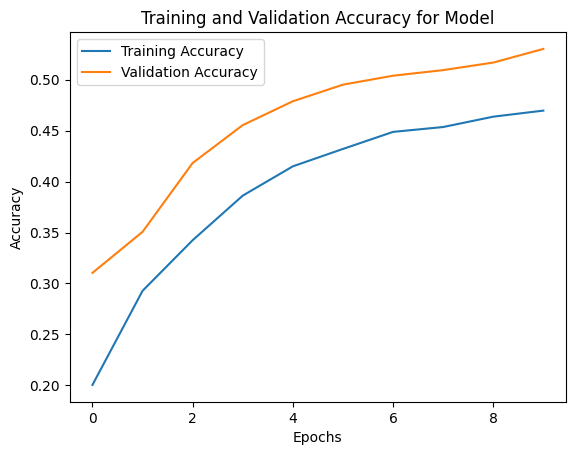

313/313 [==============================] - 3s 10ms/step - loss: 1.3546 - accuracy: 0.5303
Test Loss: 1.3545993566513062, Test Accuracy: 0.5303000211715698


In [ ]:

# Define the optimizer
optimizer = RMSprop(learning_rate=0.0001)

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

input_shape = (32, 32, 3)

# Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and report performance
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_test, y_test))

# Visualize training history for the model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Model')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")




313/313 [==============================] - 2s 7ms/step


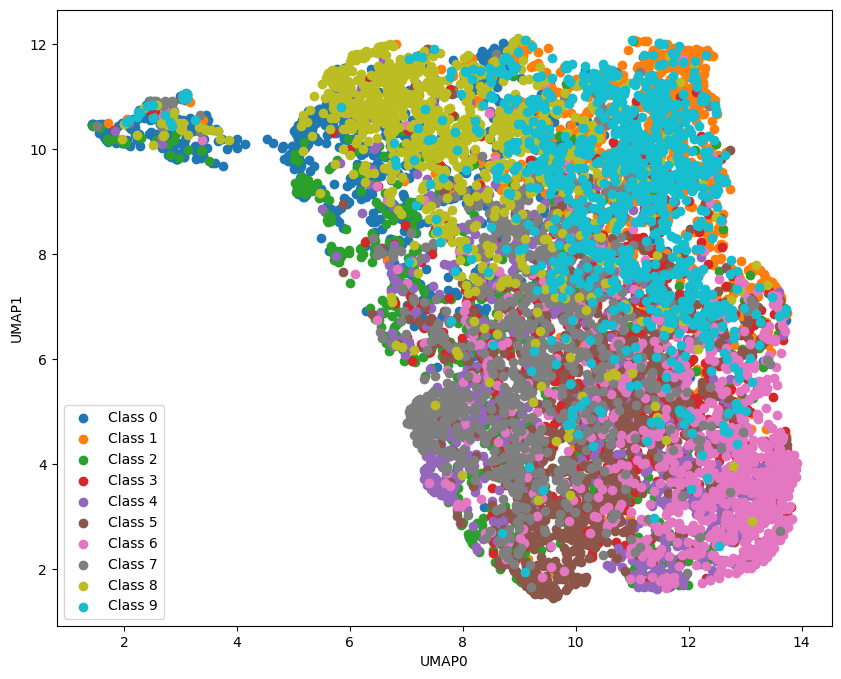

In [ ]:
# Visualise the output of the penultimate Dense(z) layer on a subset of test data
penultimate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
penultimate_output = penultimate_layer_model.predict(x_test)

# Visualise embeddings
visualise_embedding(penultimate_output, y_test)

References:


Improving Accuracy - https://saturncloud.io/blog/how-to-improve-accuracy-in-neural-networks-with-keras/

Optimizer RMSprop - https://medium.com/@francescofranco_39234/what-is-rmsprop-0f54effc47e4

Layers - https://keras.io/api/layers/regularization_layers/dropout/

Densenet - https://keras.io/api/applications/densenet/

Visual Geometry Group - https://keras.io/api/applications/vgg/

Coding - https://www.tensorflow.org/tutorials/images/cnn , MNIST_conv.ipynb (CT5133)
         
         

GenAI - Used to learn the basic architecture of CNNs, to understand the working of dropout layers, different types of optimizers.

Prompts:
1. The basic structure of a convolutional neural network
2. How does drop out layer affect the performance of  a neural network?
3. What does flatten() do?
4. Different optimisers in CNN?

